# Analisis Singkat: Prediksi Inflasi, Prediksi Banking Crisis (Attempt), dan Klasterisasi
Notebook versi **Ringkas Bersih** — berisi pipeline yang rapi dan komentar singkat setiap langkah.

**Catatan**: file data diharapkan bernama `african_crises.csv` pada lokasi yang sama (`/mnt/data/african_crises.csv`).


In [9]:
# Imports dasar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load dataset
df = pd.read_csv('african_crises.csv')
df.columns = [c.strip() for c in df.columns]
print('Shape:', df.shape)
df.head()

Shape: (1059, 12)


,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Zimbabwe,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,Zimbabwe,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,Zimbabwe,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,Zimbabwe,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,Zimbabwe,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


In [11]:
# Basic cleaning: drop duplicates, detect country/year, convert types
df = df.drop_duplicates()
# detect year column
year_col = None
for c in df.columns:
    if c.lower()=='year':
        year_col = c
        break
if year_col is None:
    raise ValueError('Year column not found (expected column named "Year" or "year")')

# detect country column
country_col = None
for c in df.columns:
    if c.lower() in ('country','countryname','country_name'):
        country_col = c
        break
if country_col is None:
    # heuristic
    obj_cols = [c for c in df.columns if df[c].dtype=='object']
    for c in obj_cols:
        if df[c].nunique()>20:
            country_col = c
            break
if country_col is None:
    raise ValueError('Country column not found automatically. Please rename country column to "Country"')

# convert year to int
df[year_col] = pd.to_numeric(df[year_col], errors='coerce').astype('Int64')
df = df.dropna(subset=[year_col, country_col])
df[year_col] = df[year_col].astype(int)
print('Using country col:', country_col, ', year col:', year_col)
df.shape

Using country col: Country , year col: year


(1059, 12)

In [12]:
# Normalize/convert expected columns
cols_needed = ['exch_usd','inflation_annual_cpi','systemic_crisis','domestic_debt_in_default',
               'sovereign_external_debt_default','gdp_weighted_default','independence',
               'currency_crises','inflation_crises','banking_crisis']

for c in ['exch_usd','inflation_annual_cpi','gdp_weighted_default']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

binary_cols = ['systemic_crisis','domestic_debt_in_default','sovereign_external_debt_default',
               'independence','currency_crises','inflation_crises']
for c in binary_cols:
    if c in df.columns:
        df[c] = df[c].replace({'yes':1,'no':0,'Y':1,'N':0,'True':1,'False':0,'true':1,'false':0})
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

# banking_crisis normalization (text -> binary)
if 'banking_crisis' in df.columns:
    df['banking_crisis_orig'] = df['banking_crisis'].astype(str)
    df['banking_crisis'] = df['banking_crisis_orig'].str.lower().map(
        lambda x: 1 if ('yes' in x or 'crisis' in x or x.strip()=='1') else 0
    ).astype(int)

df.head()

,Country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis,banking_crisis_orig
0,Zimbabwe,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1,crisis
1,Zimbabwe,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,1,no_crisis
2,Zimbabwe,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,1,no_crisis
3,Zimbabwe,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,1,no_crisis
4,Zimbabwe,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,1,no_crisis


In [13]:
# Forecast inflation for next 15 years per country
forecast_horizon = 15
countries = df[country_col].unique()
forecasts = []
details = {}

for country in countries:
    sub = df[df[country_col]==country].sort_values(by=year_col)
    if 'inflation_annual_cpi' not in sub.columns:
        continue
    series = sub['inflation_annual_cpi'].dropna()
    if len(series) >= 5:
        try:
            model = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method='estimated')
            fit = model.fit(optimized=True)
            pred = fit.forecast(forecast_horizon)
            last_year = sub[year_col].max()
            for i, val in enumerate(pred, start=1):
                forecasts.append((country, int(last_year+i), float(val)))
            details[country] = {'history_years': sub[year_col].tolist(),
                                'history_values': series.tolist(),
                                'pred_years':[int(last_year+i) for i in range(1,forecast_horizon+1)],
                                'pred_values':[float(v) for v in pred]}
        except Exception:
            mean_val = float(series.mean())
            last_year = sub[year_col].max()
            for i in range(1, forecast_horizon+1):
                forecasts.append((country, int(last_year+i), mean_val))
            details[country] = {'history_years': sub[year_col].tolist(),
                                'history_values': series.tolist(),
                                'pred_years':[int(last_year+i) for i in range(1,forecast_horizon+1)],
                                'pred_values':[mean_val]*forecast_horizon}
    else:
        if len(series)>0:
            mean_val = float(series.mean())
        else:
            mean_val = float(df['inflation_annual_cpi'].dropna().median())
        last_year = sub[year_col].max() if len(sub)>0 else df[year_col].max()
        for i in range(1, forecast_horizon+1):
            forecasts.append((country, int(last_year+i), mean_val))
        details[country] = {'history_years': sub[year_col].tolist(),
                            'history_values': series.tolist(),
                            'pred_years':[int(last_year+i) for i in range(1,forecast_horizon+1)],
                            'pred_values':[mean_val]*forecast_horizon}

df_forecast = pd.DataFrame(forecasts, columns=[country_col,'year','forecast_inflation_annual_cpi'])
out_path = Path('/mnt/data/inflation_forecasts.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
df_forecast.to_csv(out_path, index=False)
print('Saved forecast to', out_path)
df_forecast.head()

Saved forecast to \mnt\data\inflation_forecasts.csv


,Country,year,forecast_inflation_annual_cpi
0,Zimbabwe,2015,3.642515
1,Zimbabwe,2016,3.622070
2,Zimbabwe,2017,3.601625
3,Zimbabwe,2018,3.581180
4,Zimbabwe,2019,3.560735


In [14]:
# Attempt to build banking_crisis classifier (may fail if target lacks variation)
feat_candidates = ['exch_usd','inflation_annual_cpi','systemic_crisis','domestic_debt_in_default',
                   'sovereign_external_debt_default','gdp_weighted_default','independence',
                   'currency_crises','inflation_crises']
available_feats = [c for c in feat_candidates if c in df.columns]
print('Features available:', available_feats)

if 'banking_crisis' in df.columns:
    df_clf = df.dropna(subset=[ 'banking_crisis']+available_feats).copy()
    for c in available_feats:
        if df_clf[c].dtype.kind in 'biufc':
            df_clf[c] = df_clf[c].fillna(df_clf[c].median())
    X = df_clf[available_feats]
    y = df_clf['banking_crisis']
    if len(y.unique())>1:
        rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(rf, X, y, cv=cv, scoring='f1')
        print('CV F1 scores:', scores, 'mean=', scores.mean())
        # fit on full
        rf.fit(X, y)
        # holdout report
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        rf2 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
        rf2.fit(Xtr, ytr)
        ypred = rf2.predict(Xte)
        print('Classification report on holdout:')
        print(classification_report(yte, ypred))
        print('Confusion matrix:')
        print(confusion_matrix(yte, ypred))
    else:
        print('Target "banking_crisis" lacks variation; cannot train classifier reliably.')
else:
    print('Column "banking_crisis" not present in dataset.')

Features available: ['exch_usd', 'inflation_annual_cpi', 'systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default', 'gdp_weighted_default', 'independence', 'currency_crises', 'inflation_crises']
Target "banking_crisis" lacks variation; cannot train classifier reliably.


In [15]:
# Clustering: sum exch_usd & inflation per country, then KMeans
agg = df.groupby(country_col).agg({
    'exch_usd':'sum' if 'exch_usd' in df.columns else 'sum',
    'inflation_annual_cpi':'sum' if 'inflation_annual_cpi' in df.columns else 'sum'
}).reset_index().fillna(0)

agg = agg.rename(columns={'exch_usd':'sum_exch_usd','inflation_annual_cpi':'sum_inflation_annual_cpi'})
Xagg = agg[['sum_exch_usd','sum_inflation_annual_cpi']].values
scaler = StandardScaler()
Xscaled = scaler.fit_transform(Xagg)

best_k = 2
best_score = -1
scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xscaled)
    score = silhouette_score(Xscaled, labels)
    scores[k]=score
    if score>best_score:
        best_score=score
        best_k=k
print('Silhouette scores:', scores, '=> selected k=', best_k)

km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
agg['cluster'] = km.fit_predict(Xscaled)
out_cluster = Path('/mnt/data/cluster_by_exch_inflation_sum.csv')
agg.to_csv(out_cluster, index=False)
print('Saved clustering to', out_cluster)
agg.head(20)

Silhouette scores: {2: 0.6626390696623061, 3: 0.6641327146902004, 4: 0.5686649590914367, 5: 0.41144413096251414, 6: 0.3907453761772883} => selected k= 3
Saved clustering to \mnt\data\cluster_by_exch_inflation_sum.csv


,Country,sum_exch_usd,sum_inflation_annual_cpi,cluster
0,Rwanda,1818.702000,2.205950e+07,2
1,Senegal,3882.337163,2.280696e+03,0
2,Seychelles,196.004611,5.917037e+02,0
3,Somalia,2337.061326,8.860117e+02,0
4,Sudan,439.898200,6.510268e+02,0
5,Tanzania,2993.439974,1.050709e+03,0
6,Togo,155.936924,7.381768e+02,0
7,Tunisia,9659.200000,3.848830e+02,0
8,Uganda,21325.791834,3.392921e+02,1
9,Zambia,1162.674665,1.171097e+04,0


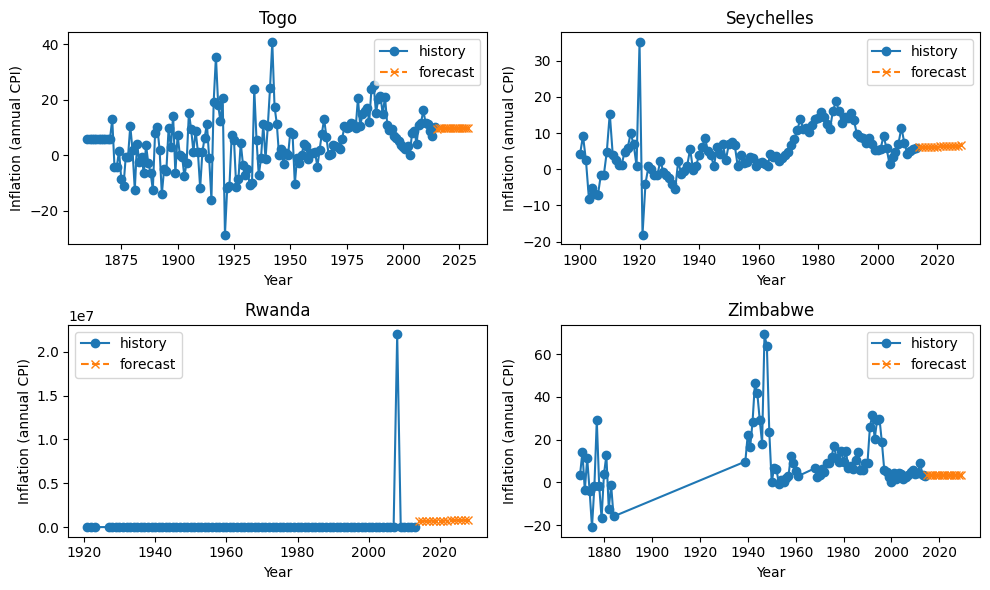

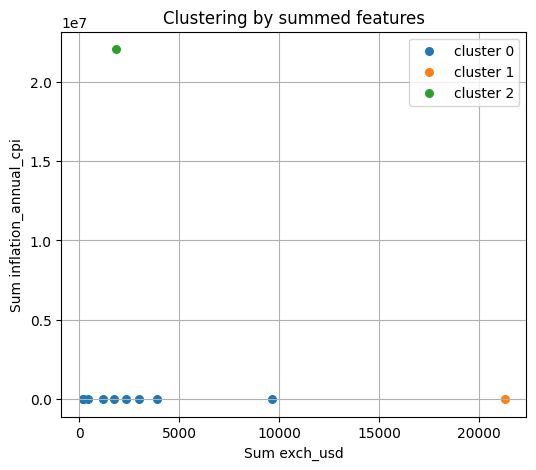

In [16]:
# Visual: show top countries' forecast and cluster scatter
import matplotlib.pyplot as plt

# show forecast example for up to 4 countries with most history
country_counts = df.groupby(country_col)[year_col].nunique().sort_values(ascending=False)
top_countries = country_counts.head(4).index.tolist()

plt.figure(figsize=(10,6))
for i, country in enumerate(top_countries, start=1):
    det = details.get(country)
    plt.subplot(2,2,i)
    if det and det['history_years']:
        plt.plot(det['history_years'], det['history_values'], marker='o', label='history')
    if det:
        plt.plot(det['pred_years'], det['pred_values'], marker='x', linestyle='--', label='forecast')
    plt.title(country)
    plt.xlabel('Year')
    plt.ylabel('Inflation (annual CPI)')
    plt.legend()
plt.tight_layout()
plt.show()

# Cluster scatter
plt.figure(figsize=(6,5))
for cl in sorted(agg['cluster'].unique()):
    sub = agg[agg['cluster']==cl]
    plt.scatter(sub['sum_exch_usd'], sub['sum_inflation_annual_cpi'], label=f'cluster {cl}', s=30)
plt.xlabel('Sum exch_usd')
plt.ylabel('Sum inflation_annual_cpi')
plt.title('Clustering by summed features')
plt.legend()
plt.grid(True)
plt.show()

## Selesai
Notebook ringkas ini menyimpan dua output utama di `/mnt/data/`:

- `inflation_forecasts.csv` — prediksi inflasi 15 tahun per negara
- `cluster_by_exch_inflation_sum.csv` — hasil klasterisasi negara

Jika ingin, jalankan notebook ini di environment yang sama (file dataset pada `/mnt/data/african_crises.csv`).